In [1]:
import math
import importlib

import pickle

import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.ax_helper import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords
import logging
from src.ax_helper import silence_ax_client, get_full_strategy
from src.toy_functions import Hartmann6D
import pickle

silence_ax_client()


-0.0 -0.9874311636230129


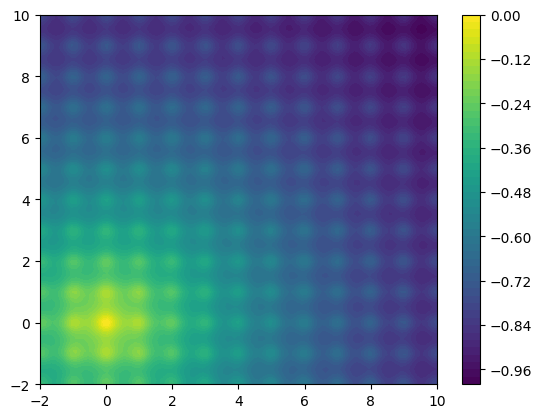

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0   1.354486   7.417548
2         2_0  14.813556  63.361007
3         3_0  40.550835   2.574729
4         4_0   3.707387  30.139747
5         5_0   7.466545   1.176193
6         6_0  68.268384  10.138573
7         7_0  24.939890   4.446764
8         8_0   2.727790  51.591240
9         9_0   1.822676   2.368844
10       10_0  19.232428  19.885430
11       11_0  93.594932   8.062191
12       12_0   8.869127  96.033629
13       13_0   5.449696   3.756117
14       14_0  51.645493  31.818152
15       15_0  10.612785   1.392453
16       16_0   1.119917  16.439002
17       17_0   1.195071   1.769442
18       18_0  12.618545  14.988979
19       19_0  46.057753   3.417231
20       20_0   4.362485  40.343131
21       21_0   8.500235   8.952213
22       22_0  80.506399  75.149998
23       23_0  22.055749   1.849482
24       24_0   2.328658  22.030311
25       25_0   2.759105   5.540808
26       26_0  30.195636  47

<Axes: xlabel='x0', ylabel='x1'>

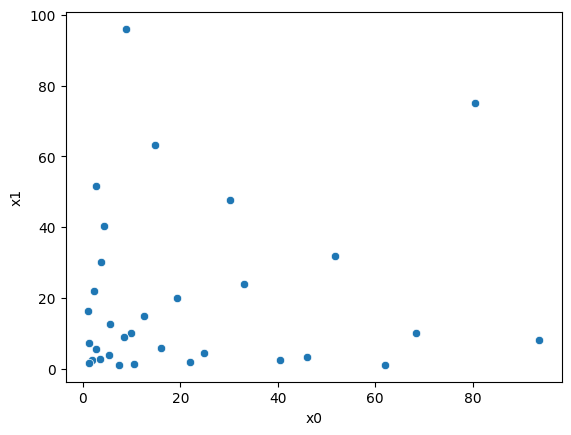

In [3]:
client = Client()


client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling="log",
        )
        for i in range(len(dim_names))
    ],
)

client.configure_optimization(objective="-loss")
client.get_next_trials(max_trials=32)
coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

<Axes: xlabel='x1', ylabel='x2'>

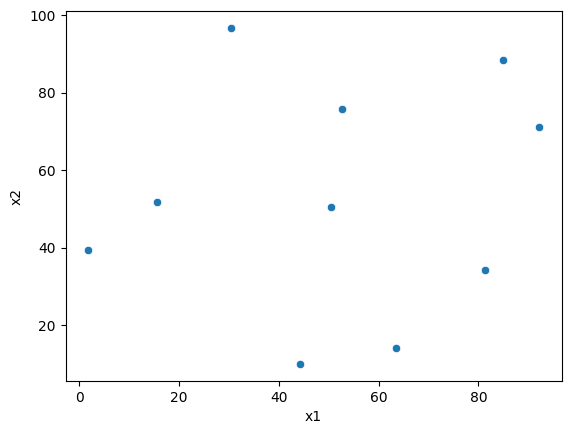

In [4]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}>,
        <Axes: title={'center': 'GP along x2'}>], dtype=object))

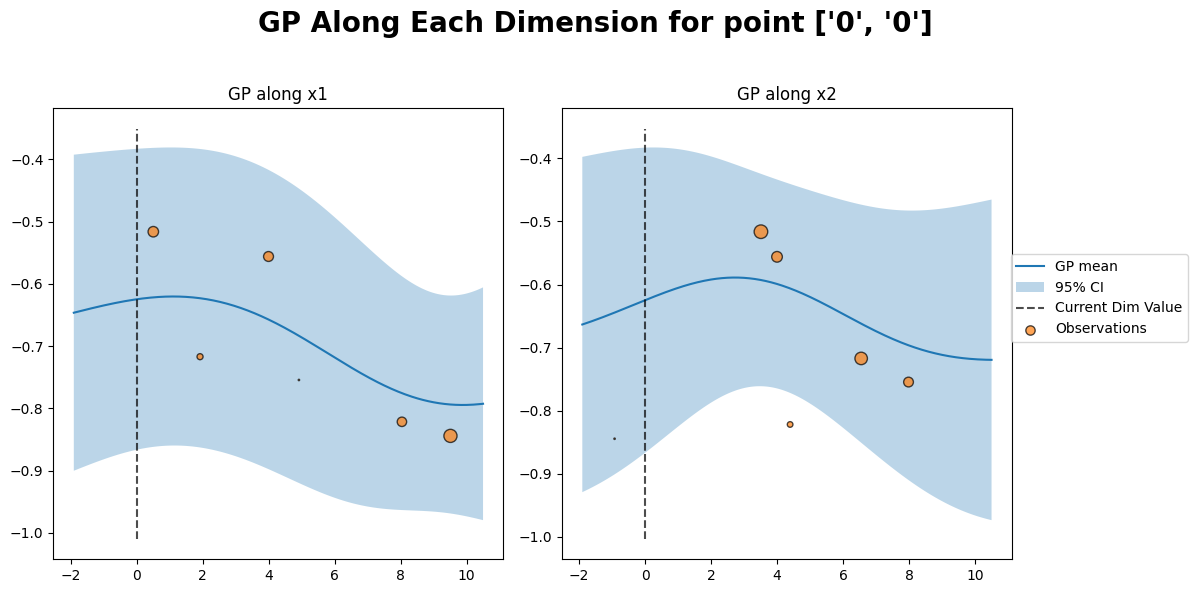

In [5]:

from src import ax_helper
importlib.reload(GPVisualiser)

client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)


batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client)
plotter = GPVisualiser.GPVisualiserMatplotlib.init_from_client(client)
plotter.plot_all([0,0])

In [6]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,4.920830,7.984767,-0.754530
2,2_0,0.508857,3.512546,-0.516259
3,3_0,1.924787,6.549892,-0.717092
4,4_0,9.512906,-0.922202,-0.844371
5,5_0,8.042098,4.396680,-0.821737


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [7]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=1, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

In [8]:
import matplotlib.pyplot as plt
for _ in range(10):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()


In [9]:

pickle.dump(batch_handler.client, open("data/ax_clients/ackley_client.pkl", "wb"))

In [10]:
pickle.load(open("data/ax_clients/ackley_client.pkl", "rb"))

In [11]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,4.920830,7.984767,-0.754530
2,2_0,0.508857,3.512546,-0.516259
3,3_0,1.924787,6.549892,-0.717092
4,4_0,9.512906,-0.922202,-0.844371
5,5_0,8.042098,4.396680,-0.821737


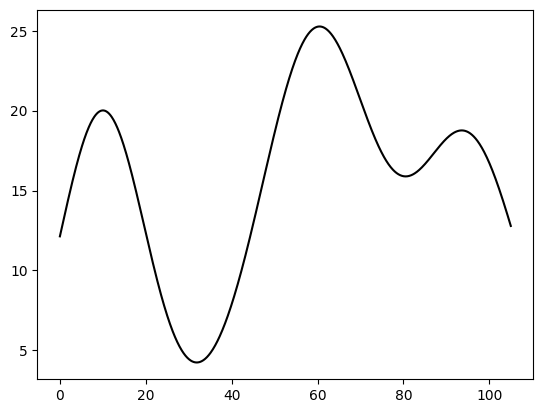

In [12]:
def gaussian(x, amplitude, mean, stddev):

    return amplitude * np.exp(-((x - mean)**2) / (2 * stddev**2))


def test_function(x1):
    x=x1
    """Three Gaussian peaks, increasing in height and steepness."""
    return (
        gaussian(x, 20, 10, 10) +  # Left peak (smallest)
        gaussian(x, 25, 60, 13) +  # Middle peak
        gaussian(x, 18, 95, 12)    # Right peak (largest, steepest)
    )


def plot_test(fig=None):
    linspace = np.linspace(0, 105, 1000)
    if fig:
        import plotly.graph_objects as go


        fig.add_trace(go.Scatter(
            x=linspace,
            y=[test_function(x) for x in linspace],
            mode="lines",
            name="True function",
            line=dict(color="black")
        ))
      #  fig.show()
    else:
        fig= plt.plot(
            linspace,
            [test_function(x) for x in linspace],
            color="black",
            label="True function",
        )
   # return fig

plot_test()

# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [13]:
range_parameters = [
    RangeParameterConfig(name="x1", parameter_type="float", bounds=(0, 100))
]

metric_name = "response"
dim_names = ["x1"]




noise_fn = lambda x, y: y

In [14]:
from src import ax_helper
importlib.reload(ax_helper)

<module 'src.ax_helper' from 'c:\\GitHub\\imperial\\src\\ax_helper.py'>

In [19]:
def update_layout(fig, title):
    plot_test(fig)
    fig.update_layout(
        margin=dict(l=20, r=20, t=40, b=20),
        title=dict(
            text=f"<b>{title}</b>",
            x=0.5,
            xanchor='center',
            font=dict(color='black')
        ),
        annotations=[],  # clear all annotations, or set as needed
        legend=dict(
            x=1,
            y=0,
            xanchor='right',
            yanchor='bottom'
        )
    )
    if hasattr(fig.layout, 'annotations') and len(fig.layout.annotations) > 0:
        fig.layout.annotations = tuple(a for a in fig.layout.annotations if getattr(a, 'text', None) != "GP along x1")

    fig.update_yaxes(range=[0, 28])

    file_name = title.replace(" ", "-").lower()
    write_params = dict(width=1000, height=600, scale=5)
    fig.write_image(f"images/{file_name}.png", **write_params)
    fig.write_image(f"images/{file_name}.svg", **write_params)
    #fig.write_html(f"images/{file_name}.html", )
    fig.show()

In [26]:
tester = ax_helper.SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=2,
    technical_repeats=0,
    batch_size=1,
    noise_fn=noise_fn,
    plot_each=False,
)
#tester.handler.get_next_batch(1)
fig = runs.plot_GP(SingleTaskGP, figsize=(12,4))

update_layout(fig, "Gaussian Process after 2 Observations")

In [23]:
for i in [4, 6, 8, 10]:
    runs.get_next_batch(1)
    runs.complete_all_pending()
    runs.get_next_batch(1)
    fig = runs.plot_GP(SingleTaskGP, figsize=(12,4))


    update_layout(fig, f"Gaussian Process after {i} Observations")

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

In [18]:
break


SyntaxError: 'break' outside loop (370545404.py, line 1)

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

In [ ]:
from src.gp_and_acq_f import custom_gp_and_acq_f as mg


runs = tester.run(
    mg.GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(mg.GammaNoiseSGP, figsize =(12, 4))


plot_test(runs)

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

In [ ]:
runs = tester.run(mg.GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(mg.GammaNoiseSGP, figsize=(8, 4))
plot_test(runs)

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-iSV9AhHi-py3.11\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-iSV9AhHi-py3.11\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Heteroscedastic noise

In [ ]:
def noise_fn_low(x, y= None):
    return y + np.random.normal(0, 1)*(x['x1']+2)/12


runs = tester.run(mg.GammaNoiseSGP, n_runs=4, technical_repeats=3, batch_size=3, noise_fn=noise_fn_low, plot_each=False)
fig =runs.plot_GP(mg.GammaNoiseSGP, figsize=(12, 4))
plot_test(fig)

* The white noise kernel is unable to accommodate linear heteroscedastic noise.

## Technical repeat adaptive kernel

In [ ]:
importlib.reload(mg)
fig = runs.plot_GP(mg.HeteroNoiseSGP, figsize=(12, 4))
plot_test(fig)

* Fitting a gp to pre-investigated data appear perform quite badly 

## Heteroscedastic + fixed white noise

In [ ]:
fig = runs.plot_GP(mg.HeteroWhiteSGP, figsize=(12, 4))
plot_test(fig)

Much better performance when data is acquired during the run.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [ ]:


save_dir = "data/bayes_sim/"
h6 = Hartmann6D().eval_at

_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = [float(h6(*_h6_x_opt)) for _ in range(10000)]
h_6_max

[3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701

In [ ]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = ax_helper.SequentialRuns(h6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester

## Sequential runs no noise

In [ ]:
def noise_fn(x, y):
    return y

save_dir = "data/bayes_sim/"
runs = tester.run(SingleTaskGP, n_runs=40, technical_repeats=2, batch_size=1, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(SingleTaskGP, figsize=(12, 6))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000214AB9F0990>>
Traceback (most recent call last):
  File "c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-iSV9AhHi-py3.11\Lib\site-packages\ipykernel\ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


* Save the data for our testing purposes

In [ ]:
client_dir = r"data/ax_clients/"
runs.client.save_to_json_file(client_dir + "hartmann6_runs.json")

In [ ]:
client = Client().load_from_json_file(client_dir + "hartmann6_runs.json")
ax_helper.get_obs_from_client(client)

,trial_name,x1,x2,x3,x4,x5,x6,response
0,0_0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.516406
1,0_0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.516406
2,2_0,0.046521,0.713510,0.134521,0.796270,0.815798,0.060014,0.161594
3,2_0,0.046521,0.713510,0.134521,0.796270,0.815798,0.060014,0.161594
4,4_0,0.646256,0.155144,0.622058,0.110679,0.301389,0.888113,0.975021
...,...,...,...,...,...,...,...,...
76,76_0,0.194270,0.157655,0.481083,0.271780,0.306100,0.660047,3.415544
77,76_0,0.194270,0.157655,0.481083,0.271780,0.306100,0.660047,3.415544
78,78_0,1.000000,0.611282,0.671193,0.855928,0.887875,0.228606,0.001110
79,78_0,1.000000,0.611282,0.671193,0.855928,0.887875,0.228606,0.001110
